# 0. Preamble

In order to fully understand the following analysis, some key terms must be defined.

- A **Correct Detection** of a synapse occurs when, after the binarization step, the pipeline identifies at least 1 voxel in a synapse cluster as synapse by scoring it with a 1. Each synapse cluster can only be correctly detected once

- An **Incorrect Detection** of a synapse occurs when, after the binarization step, the pipeline identifies a voxel as synapse by scoring it with a 1, even though said voxel is not in a ground truth synapse cluster.

- The **Probability of Detection (PD)** is the fraction $\frac{\text{Correct Detections}}{\text{True Number of Synapses}}$ This is the same formula as **Recall**

- The **False Alarm Rate (FAR)** is the fraction $\frac{\text{Incorrect Detections}}{\text{Total Detections}}$ This can be thought of as the **False Positive Rate**

# Simulation Data

## 1. Write Sampling Distributions
### Functionality Data
The easy case and failure case tests for our algorithm will utilize data that we have created for prior unit tests. These files will be loaded from pickle files on our repo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')

easySim = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
hardSim = pickle.load(open('../code/tests/synthDat/all100.synth'))


#### i.
For the easySim, I expect the algorithm to correctly identify both 'synapse' clusters in the data, and not identify any non synapse voxels as cluster. This will result in a **PD of 100%** and a **FAR of 0%**

For the hardSim, I expect the algorithm to identify both synapse clusters, and the noise in the data, as synapse. This would result in a **PD of 100% and a FAR of ~99%**

#### ii.
I expect the algorithm to perform very well on easySim, since the volume is small, and the clusters are not obscured by any noise.

I expect the algorithm to perform very poorly on the hardSim, since the volume is fully saturated with noise, and there is no way for the pipeline to differentiate synapse from noise.

### Validation Data

#### Success

In addition to these base easy and difficult cases, we will generate data volumes with the following properties:

- 100x100x100 Voxels
- 98% Non-Synapse, 2% Synapse
- Synapses clustered into 2 micron$^3$ clusters (~27 voxels)

In order to test how the algorithm performs on data that mimics real world data.

The code below will perform this generation routine

In [2]:
from random import randrange as rand
from skimage.measure import label

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

#### i. 
The ground truth for each point set is returned as the first of two unpacked values from the generateTestVolume function. In this way, we can compare every test trial to the ground truth.

#### ii.
I expect the algorithm to perform very well on tihs data, since it was designed to filter out noise and identify synapses of the size in the synthetic data.

#### Failure

I will also generate a data volume to simulate poor data that the pipeline would not work well on. This data will have the following properties:

- 100x100x100 Voxels
- 98% Non-Synapse, 2% Synapse
- Synapses clustered into ~.5 micron$^3$ clusters (~8 voxels)

In order to test how the algorithm performs on very poor quality data. 

The code below will perform this generation routine


In [16]:
def generatePoorPointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 1):
        for y in range(-1, 1):
            for x in range(-1, 1):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generatePoorTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePoorPointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePoorPointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

## 2. Write code to sample data

The above data can be sampled in one of three ways
1. Through the easySim variable
2. Through the hardSim variable
3. Though the generateTestVolume function
4. Through the generatePoorTestVolume function

## 3. Describe in words what I expect the simulations to look like

- Based on our prior testing, I **expect a mean PD of ~97%** and a **mean far of 0%** for the generateTestVolume Data. 

- Based on our prior testing, I **expect a mean PD 0f ~4%** and a **mean far of 0%** for the generatePoorTestVolume Data.

- My expectations for the easySim and hardSim data can be found in **Simulation Data Section 1 - Functionality Testing - i**

## 4/5. Write code to plot and plot the sim data

### Functionality Data

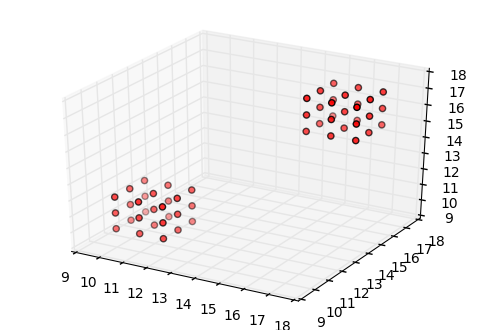

In [4]:
#The easy sim data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = easySim.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

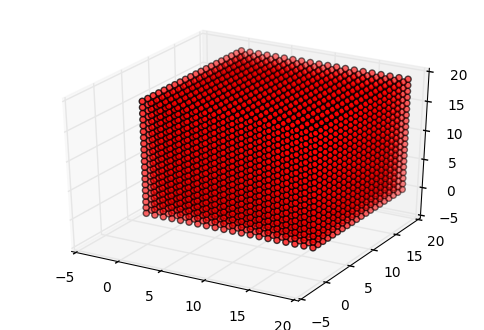

In [5]:
#The hard sim data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = hardSim.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

### Validation Data

#### Success Data

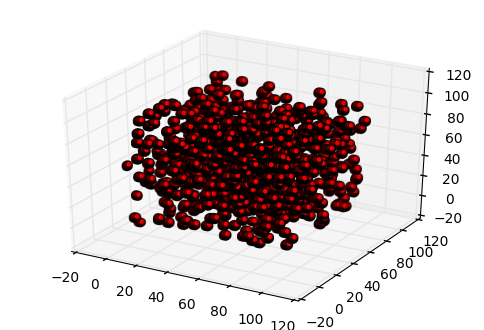

In [6]:
#One instance of generated data
truth, test = generateTestVolume()

#The ground truth data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = truth.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

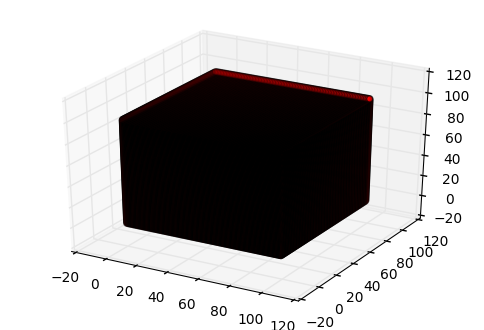

In [7]:
#The test data (has noise)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = test.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [8]:
synapseDensity = len(zip(*truth.nonzero()))/float(100*100*100)

def getAveSynSize(volume):
    lVolume = label(volume)
    aveSum = []
    #starting at 1 since we dont want to count the background label
    for i in range(1, np.max(lVolume)+1):
        aveSum.append(len(zip(*np.where(lVolume == i))))
    return np.average(aveSum), aveSum

print 'Percent Synapse by Volume: ', synapseDensity*100., '%'
aveSize, sizeList = getAveSynSize(truth)
print 'Average Synapse Size: ', aveSize

Percent Synapse by Volume:  2.1033 %
Average Synapse Size:  28.8518518519


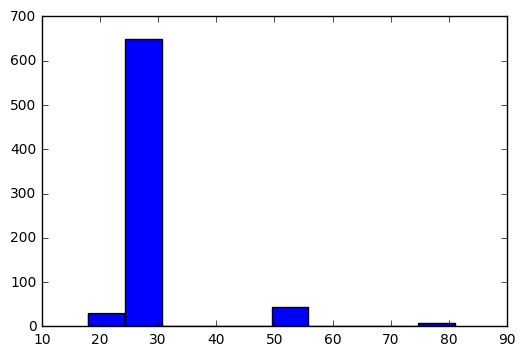

In [11]:
#Generate a histogram of synapse sizes in voxels
fig = plt.figure()
plt.hist(sizeList)
plt.show()

#### Failure Data

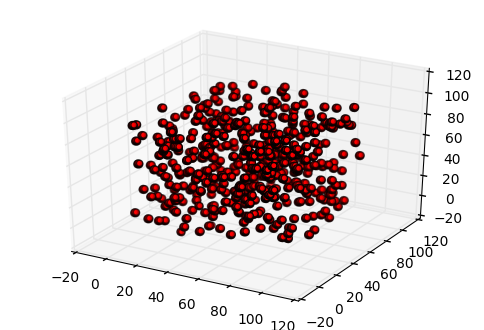

In [17]:
#One instance of generated data
truth, test = generatePoorTestVolume()

#The ground truth data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = truth.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

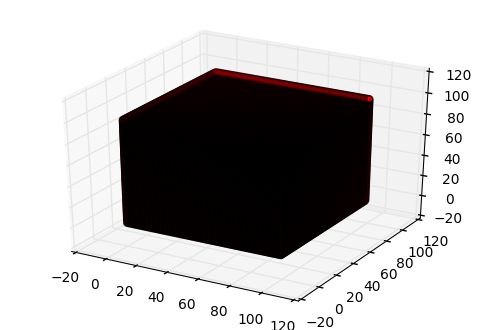

In [18]:
#The test data (has noise)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = test.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [19]:
synapseDensity = len(zip(*truth.nonzero()))/float(100*100*100)
print 'Percent Synapse by Volume: ', synapseDensity*100., '%'
aveSize, sizeList = getAveSynSize(truth)
print 'Average Synapse Size: ', aveSize

Percent Synapse by Volume:  0.4052 %
Average Synapse Size:  8.07171314741


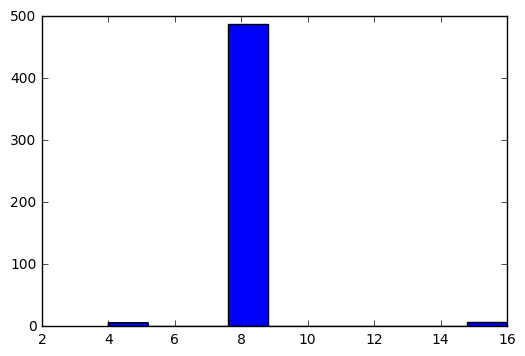

In [20]:
#Generate a histogram of synapse sizes in voxels
fig = plt.figure()
plt.hist(sizeList)
plt.show()

### 6. Report whether it looks right
#### Functionality Data
The functionality data is confirmed to be correct from the visualizations.

#### Validation Data

##### Success Data
The validation data shows a percent synapse by bolume of 2.1033%, and an average synapse size of 28.851 voxels. This is consistent with the density and size metrics of our actual data. The histogram of synapse sizes shows four peaks. Each of these peaks can be explained in an intuitive and expeted way:

- The peak in the bin around 20 is full of the cluster who were generated at the edges of the 100x100x100 volume, making their total volumes slightly smaller than the 27 voxel expected volume.

- The peak around 27 is the large set of clusters who were generated not touching any other cluster. They have a volume of 27 voxels

- The peak around 54 is a small set of 2 clusters who were generated ajacently to eachother, resulting in one large cluster. The algorithm will likely have trouble identifying these clusters as separate in some cases.

- The peak around 81 is the small set of 3 clusters who were generated ajacently to eachother, resulting in one large cluster. The algorithm will likely have trouble identifying these clusters as separate in some cases.

##### Failure Data
The validation data shows a percent synapse by bolume of .4052%, and an average synapse size of 8.071 voxels. This is consistent with the reduced metrics that we were aiming for in the failure data. The histogram of synapse sizes shows three peaks. Each of these peaks can be explained in an intuitive and expected way:

- The peak in the bin around 4 pixelsis full of the cluster who were generated at the edges of the 100x100x100 volume, making their total volumes slightly smaller than the 8 voxel expected volume.

- The peak around 8 is the large set of clusters who were generated not touching any other cluster. They have a volume of 8 voxels

- The peak around 16 is a small set of 2 clusters who were generated ajacently to eachother, resulting in one large cluster. 


## Simulation Analysis

### 1. Write Algorithm Pseudocode

**INPUTS** - A 3D volume containing voxels with intensities 0 to 65534

**OUTPUTS** - A 3D volume labeling synapse voxels as 1 and non synapse voxels as 0 

In [ ]:
######################################
###THIS IS PSEUDOCODE; WILL NOT RUN###
######################################

###STEP 1: COMPUTATION OF FOREGROUND PROBABILITY###
cdfMapVolume = []
for image in volume:
    
    #Get a distribution of intensities of the slice
    dist = generateDistribution(image)
    
    #Get the cdf for every voxel in the image slice
    cdfMap = zeros_like(dist)
    for y in image.height:
        for x in image.width:
            cdfMap[y][x] = dist.cdf(image[y][x])
    cdfMapVolume.apend(cdfMap)
    
####Step 2: Probability of 2D Puncta
filteredVolume = zeros_like(cdfMapVolume)
for z in cdfMapVolume.depth:
    for y in cdfMapVolume.height:
        for x in cdfMapVolume.width:
            #NOTE: boxFilter apples a box filter(duh...) of size at the given zyx
            #this boxFilter is equivalent to the product of all elements that are <=size
            #away from the zyx center, and are on the same z slice.
            filteredVolume[z][y][x] = boxFilter(cdfMapVolume, z, y, x, size)
            
####Step 3: Probability of 3D Puncta
finalVolume = zeros_like(filteredVolume)
for z in filteredVolume.depth:
    for y in filteredVolume.height:
        for x in filteredVolume.width:
            #getSquaredError calculates the sum of the squared error between the provided zyx voxel
            #and the voxel at the same yx points within size distance of z (i.e. up and down z axis)
            finalVolume[z][y][x] = filteredVolume[z][y][x] * exp(-1 * getSquaredError(filteredVolume, z, y, x, size))

### 2. Write Algorithm Code
All code for this PLOS Pipeline can be found in our plosLib.py file, located here:

https://github.com/NeuroDataDesign/pan-synapse/blob/master/code/functions/plosLib.py

### 3. Description of predicted easy sim performance
- My expectations for the easySim and hardSim data can be found in **Simulation Data Section 1 - Functionality Testing - i**

### 4. Generate the simulated data
- The simulated data was generated in **Simulation Data Section 1** and can be verified and viewed in **Simulation Data Section 5 & 6**

### 5. Run the algoithm on simulated data

In [7]:
import plosLib as pLib
import connectLib as cLib

# success test
twoClusterResults = pLib.pipeline(easySim)
bianTwoClusterResults = cLib.otsuVox(twoClusterResults)

# failure test
uniformResults = pLib.pipeline(hardSim)
bianUniformResults = cLib.otsuVox(uniformResults)

/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


### 6. Plot the results

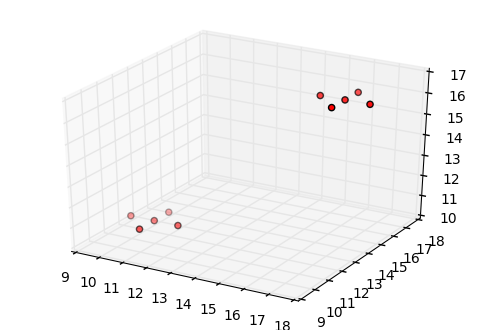

In [26]:
#The binary two cluster results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = bianTwoClusterResults.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

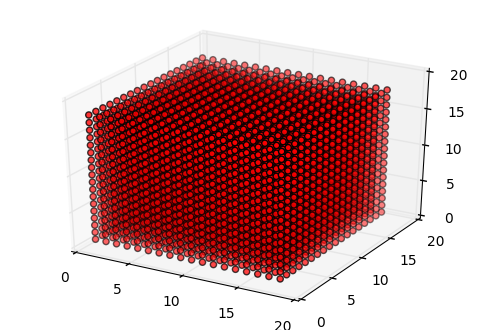

In [27]:
#The binary two cluster results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = uniformResults.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

### 7. Describe the metric for quantifying performance
- I plan to use **Probability of Detection (PD)** and **False Alarm Rate (FAR)** to quantify performance. Definitions for these metrics can be found in **Section 0: Preamble**

- I will compute these metrics for a permutation algorithm on the same data as a null comparison

### 8. Write code to quantify the results
The code below will be used to quantify the results for the validation data tests.

#### Success Test

In [28]:
def executeTest():
    trueVolume, testVolume = generateTestVolume()
    labelVolume = label(trueVolume)
    maxLabel = np.max(labelVolume)
    
    #get pieline results
    results = cLib.otsuVox(pLib.pipeline(testVolume))
    detected = zip(*np.where(results == 1))
    
    #get random results for p value comparison
    randomResults = np.zeros_like(testVolume)
    for z in range(randomResults.shape[0]):
        for y in range(randomResults.shape[1]):
            for x in range(randomResults.shape[2]):
                randomResults[z][y][x] = rand(0, 2)
    randomDetected = zip(*np.where(randomResults == 1))
    
    #score results
    numDetected = 0
    numMistaken = 0
    alreadyCounted = []
    for point in detected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            numDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            numMistaken +=1
            
    print "\tPipeline:"
    print "\t\tPD: ", float(numDetected)/maxLabel
    print "\t\tFAR: ", float(numMistaken)/(100 * 100 *100)
    
    randNumDetected = 0
    randNumMistaken = 0
    alreadyCounted = []
    for point in randomDetected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            randNumDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            randNumMistaken +=1
    
    print "\tRandom:"
    print "\t\tPD: ", float(randNumDetected)/maxLabel
    print "\t\tFAR: ", float(randNumMistaken)/(100 * 100 *100)
    
    return float(numDetected)/maxLabel, float(numMistaken)/(100 * 100 *100), float(randNumDetected)/maxLabel, float(randNumMistaken)/(100 * 100 *100)
    

#### Failure Test

In [29]:
def executeFailureTest():
    trueVolume, testVolume = generatePoorTestVolume()
    labelVolume = label(trueVolume)
    maxLabel = np.max(labelVolume)
    
    #get pieline results
    results = cLib.otsuVox(pLib.pipeline(testVolume))
    detected = zip(*np.where(results == 1))
    
    #get random results for p value comparison
    randomResults = np.zeros_like(testVolume)
    for z in range(randomResults.shape[0]):
        for y in range(randomResults.shape[1]):
            for x in range(randomResults.shape[2]):
                randomResults[z][y][x] = rand(0, 2)
    randomDetected = zip(*np.where(randomResults == 1))
    
    #score results
    numDetected = 0
    numMistaken = 0
    alreadyCounted = []
    for point in detected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            numDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            numMistaken +=1
            
    print "\tPipeline:"
    print "\t\tPD: ", float(numDetected)/maxLabel
    print "\t\tFAR: ", float(numMistaken)/(100 * 100 *100)
    
    randNumDetected = 0
    randNumMistaken = 0
    alreadyCounted = []
    for point in randomDetected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            randNumDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            randNumMistaken +=1
    
    print "\tRandom:"
    print "\t\tPD: ", float(randNumDetected)/maxLabel
    print "\t\tFAR: ", float(randNumMistaken)/(100 * 100 *100)
    
    return float(numDetected)/maxLabel, float(numMistaken)/(100 * 100 *100), float(randNumDetected)/maxLabel, float(randNumMistaken)/(100 * 100 *100)
    

### 9. Quantify Results
Below are single runs of the results from the validation tests

In [33]:
print 'Success Test:'
pd, far, rpd, rfar = executeTest()
print 'Failure Test:'
pd, far, rpd, rfar = executeFailureTest()

Success Test:
	Pipeline:
		PD:  0.981228668942
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.491587
Failure Test:
	Pipeline:
		PD:  0.921212121212
		FAR:  0.014645
	Random:
		PD:  0.989898989899
		FAR:  0.49872


### 10. Run 10 times on success test

In [41]:
spd=[]
sfar=[]
srpd=[]
srfar=[]

for num in range(1,11):
    print "\nExecuting Test: ", num
    pd, far, rpd, rfar = executeTest()
    spd.append(pd)
    sfar.append(far)
    srpd.append(rpd)
    srfar.append(rfar)

print '\n\nAverage Performance:'
print '\tPipeline:'
print '\t\tPD: ', np.average(spd)
print '\t\tFAR: ', np.average(far)
print '\tRandom: '
print '\t\tPD: ', np.average(srpd)
print '\t\tFAR: ', np.average(srfar)


Executing Test:  1
	Pipeline:
		PD:  0.975757575758
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.494226

Executing Test:  2
	Pipeline:
		PD:  0.965023847377
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.490197

Executing Test:  3
	Pipeline:
		PD:  0.973684210526
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.492159

Executing Test:  4
	Pipeline:
		PD:  0.982633863965
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.490139

Executing Test:  5
	Pipeline:
		PD:  0.96875
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.489744

Executing Test:  6
	Pipeline:
		PD:  0.967796610169
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.49142

Executing Test:  7
	Pipeline:
		PD:  0.974257425743
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.493412

Executing Test:  8
	Pipeline:
		PD:  0.984158415842
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.493172

Executing Test:  9
	Pipeline:
		PD:  0.97124600639
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.491526

Executing Test:  10
	Pipeline:
		PD:  0.966216216216
		FAR:  0.0
	Random:
		PD:  1.0
		FAR

### 11. Run 10 times on failure test

In [40]:
fpd=[]
ffar=[]
frpd=[]
frfar=[]

for num in range(1,11):
    print "\nExecuting Test: ", num
    pd, far, rpd, rfar = executeFailureTest()
    fpd.append(pd)
    ffar.append(far)
    frpd.append(rpd)
    frfar.append(rfar)

print '\n\nAverage Performance:'
print '\tPipeline:'
print '\t\tPD: ', np.average(spd)
print '\t\tFAR: ', np.average(far)
print '\tRandom: '
print '\t\tPD: ', np.average(srpd)
print '\t\tFAR: ', np.average(srfar)


Executing Test:  1
	Pipeline:
		PD:  0.939794419971
		FAR:  0.010135
	Random:
		PD:  0.994126284875
		FAR:  0.497306

Executing Test:  2
	Pipeline:
		PD:  0.927197802198
		FAR:  0.009555
	Random:
		PD:  0.991758241758
		FAR:  0.496183

Executing Test:  3
	Pipeline:
		PD:  0.911258278146
		FAR:  0.008457
	Random:
		PD:  0.998675496689
		FAR:  0.497098

Executing Test:  4
	Pipeline:
		PD:  0.934615384615
		FAR:  0.012923
	Random:
		PD:  0.992307692308
		FAR:  0.498045

Executing Test:  5
	Pipeline:
		PD:  0.916398713826
		FAR:  0.010371
	Random:
		PD:  0.991961414791
		FAR:  0.497581

Executing Test:  6
	Pipeline:
		PD:  0.935967302452
		FAR:  0.007865
	Random:
		PD:  0.991825613079
		FAR:  0.49661

Executing Test:  7
	Pipeline:
		PD:  0.890710382514
		FAR:  0.008194
	Random:
		PD:  0.99043715847
		FAR:  0.496641

Executing Test:  8
	Pipeline:
		PD:  0.934083601286
		FAR:  0.011677
	Random:
		PD:  0.995176848875
		FAR:  0.49709

Executing Test:  9
	Pipeline:
		PD:  0.95547309833
		FAR: 

## Summarize Simulation Analysis

### 1. Describe how I will visualize results
I will create a scatter plot detailing the PD and FAR of both algorithms over their 10 tests, for both the success and failure validation tests.

### 2. Describe how I calculated the population performance
The population performance will simply be calculated as the average PD and FAR for each algorithm over the 10 tests.

### 3. Write code to display results

#### Success
Below is the PD of the pipeline (red) vs the random algorithm (blue) over 10 trials

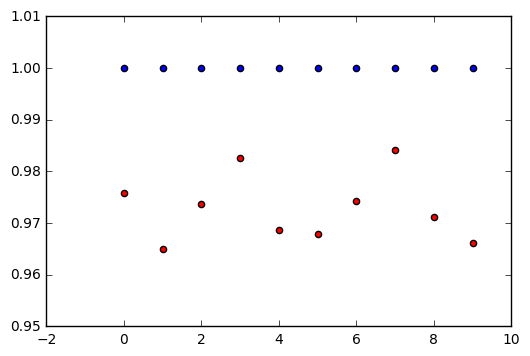

In [49]:
fig = plt.figure()
x = np.arange(10)
plt.scatter(x, spd, c='r')
plt.scatter(x, srpd, c='b')
plt.show()

Below is the FAR of the pipeline (red) vs the random algorithm (blue) over 10 trials

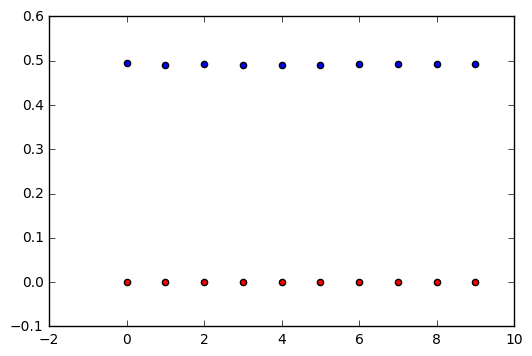

In [50]:
fig = plt.figure()
x = np.arange(10)
plt.scatter(x, sfar, c='r')
plt.scatter(x, srfar, c='b')
plt.show()

#### Failure
Below is the PD of the pipeline (red) vs the random algorithm (blue) over 10 trials

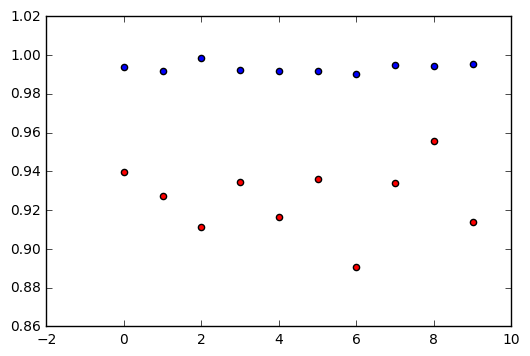

In [51]:
fig = plt.figure()
x = np.arange(10)
plt.scatter(x, fpd, c='r')
plt.scatter(x, frpd, c='b')
plt.show()

Below is the FAR of the pipeline (red) vs the random algorithm (blue) over 10 trials

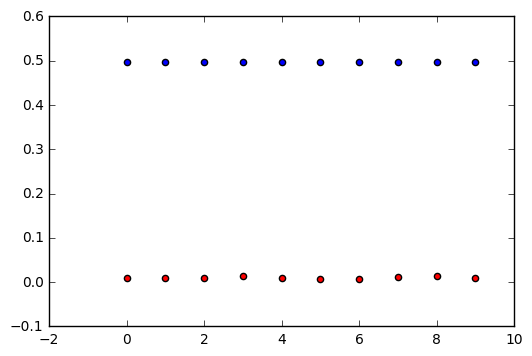

In [52]:
fig = plt.figure()
x = np.arange(10)
plt.scatter(x, ffar, c='r')
plt.scatter(x, frfar, c='b')
plt.show()

### 4. Compute population performance
The population performance is calculated and output during the simulations. Please refer to **Simulation Analysis Sections 10 & 11**

### 5. Summarize qualitative analysis
#### Success
##### PD

- The probability of detection plot shows only a small deviation in the PD between the random and the true pipeline, with both algorithms detecting over 97% of the synapses correctly. See the quantitiative section for intuition as to why this performnace is so high.

- The deviation between PD measurements in the pipeline is quite small, showing that the pipeline produces stable results.

##### FAR

- The false alarm rate plot shows a large diffrence in FAR between the random and the true pipeline. The true pipeline had virtually 0% FAR vs the random pipeline.

- The deviation between FAR measurements in the pipeline is quite small, showing that the pipeline produces stable results.

#### Failure
##### PD
- The probability of detection plot shows a slightly larget deviation in the PD between the random and the true pipeline than the success plot did. This deviation, though, is actually quite small compared to the expected output. based on the high performance in PD of the random pipeline, this means that the synapse algoithm is performing better than expected.

- The deviation between PD measurements in the pipeline is quite small, showing that the pipeline produces stable results.

##### FAR
- The false alarm rate plot shows a large diffrence in FAR between the random and the true pipeline. The true pipeline had virtually 0% FAR vs the random pipeline.

- The deviation between FAR measurements in the pipeline is quite small, showing that the pipeline produces stable results.

### 6. Summarize quantitative analysis
#### Success
Comparative to the random sampling, the actual pipeline performs ~2.2% worse in probability of detection, but has ~49% less false alarms, on average.

Some intuition behind these numbers:

- The size of volume of test synapses is 27 voxels, meaning that the random algorithm has a $1-(.5)^{27} = .999$ probability of labeling at least one voxel in the volume as true. This explains the very high PD for the random algorithm.

- The FAR of the random algorithm has a similarly simple intuition. Since 98% of the volume is 'not synapse', and the randomized algorithm has a 50% chance of labeling any one voxel as 'synapse' there is a $.98*.5=.49$ probability that it marks an incorrect voxel as correct.

- The PD of the pipeline is hovering around 98%. I believe that the reason for this not being at 100 is that the algorithm does not attempt to classify voxels where any part of the computations in its pipeline are undefined. Due to this, it will not report a true positive on synapses that are in the corners or on the edges of the volume. I intend to write a test suite to evaluate this hypothesis in the near future. 

- The FAR of the pipeline is extemely low at 0%. Under normal circumstances, this would provide evidence that hyperparameters could be tweaked such that one could increase the PD at little to no cost in FAR. However, the current default hyperparameter set is the smallest set that can be applied to this particular algorithm; meaning that it cannot be tweaked to favor detection over false alarms any more than it already is. With this in mind, we could make a few modifications to the algorithm to optimize it to the circumstances at hand. I intend to test these tweaks once the full pipeline is together and functional.

#### Failure
With a mean detection rate of ~93% and a mean far of about 1% on the failure data, the pipeline performed much better than expected on the failure data.

#### Conclusion

Overall, the pipeline performed extremely well when compared to the random algorithm. It was able to detect ~97% of synapses with ~0% false alarms

## Real Data Analysis
Just to gain some insight as to how the pipeline is performing, I wanted to run the pipeline on a select few of the real world images and generate some qualitative visualizations. Due to the size of our data, I will be loading it from a pickle file as opposed to directly from the tif images. Additionally, for processing speed reasons, I will only be running the pipeline on slices 1-3. I will be displaying slice 3 as the reference image

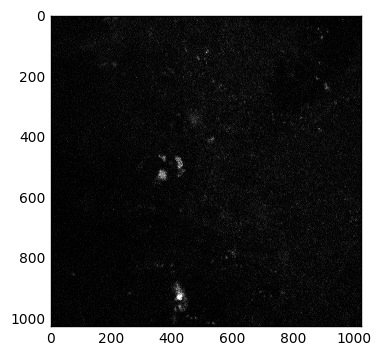

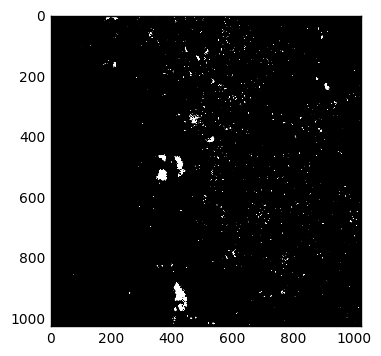

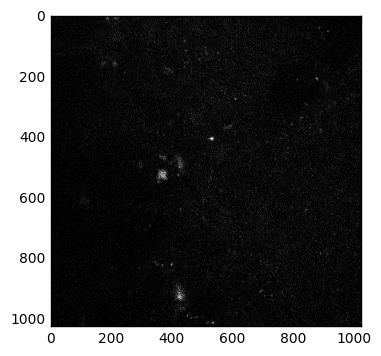

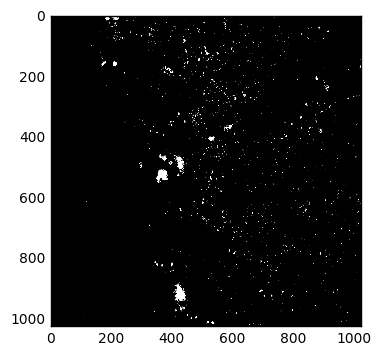

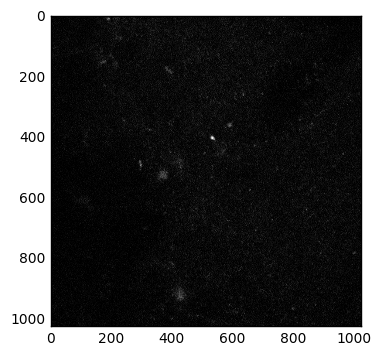

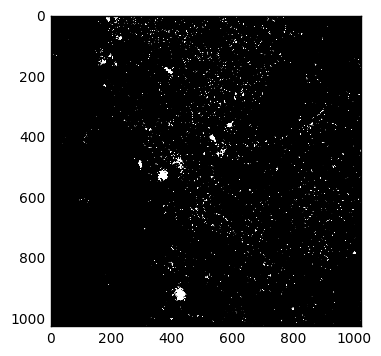

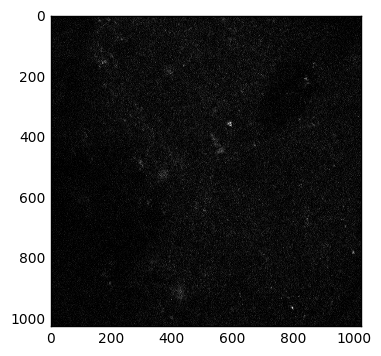

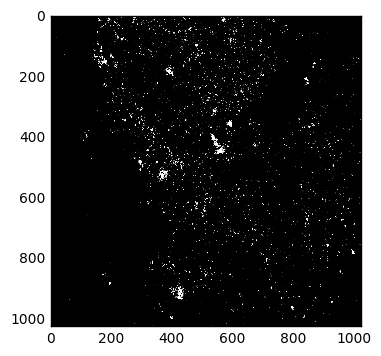

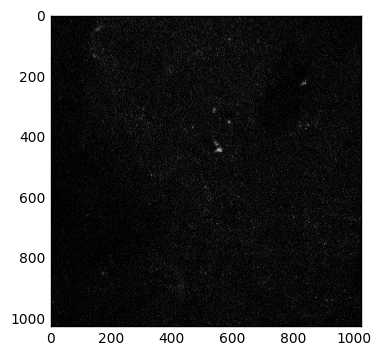

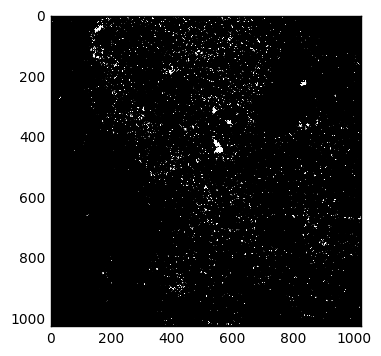

In [13]:
realData = pickle.load(open('../code/tests/synthDat/realDataRaw_t0.synth', 'r'))
for i in range(0, 5):
    realDataSection = realData[5*i:5*i + 5]
    plt.imshow(realDataSection[2], cmap='gray')
    plt.show()
    out = cLib.otsuVox(pLib.pipeline(realDataSection))
    plt.imshow(out[2], cmap='gray')
    plt.show()